## Aggregation File 

In this notebook we aggregate the key components of the analysis that we are interested in. They are not meant to be running consecutively, but rather to be used as a reference for the overall analysis that takes place. 

Here is a list of data sources used (or planned to be used) in this notebook:
- For Country shape files  [1](https://gadm.org/index.html)
-  For global population data [2](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop)
- For spatially harmonized critical infrastructure data visit [3](https://zenodo.org/records/4957647)
- For gridded spatial deprivation index visit [4](https://sedac.ciesin.columbia.edu/data/set/povmap-grdi-v1)<br>
- For urban aglomoration data visit [7](https://africapolis.org/en)
========================================================================
- For access to harmonized NTL visit [5](https://figshare.com/articles/dataset/Harmonization_of_DMSP_and_VIIRS_nighttime_light_data_from_1992-2018_at_the_global_scale/9828827/2?file=17626016)
- For access to global 1x1km GDP estimates visit [6](https://figshare.com/articles/dataset/Global_1_km_1_km_gridded_revised_real_gross_domestic_product_and_electricity_consumption_during_1992-2019_based_on_calibrated_nighttime_light_data/17004523/1?file=31456837)
- For access to global 1x1km electricity Consumption estimates visit [6](https://figshare.com/articles/dataset/Global_1_km_1_km_gridded_revised_real_gross_domestic_product_and_electricity_consumption_during_1992-2019_based_on_calibrated_nighttime_light_data/17004523/1?file=31456837)


Sources [3] and [4] are currently not included in the analysis. However they should be added similar to the population data as single datapoint for each grid cell through averaging/summing.
Similarly, sources [5] and electricity consumption of [6] should be added similar to the generated time series data for each cell of gdp.<br>




Before running make sure to activate the environment via the following command:<br>
<br>
REMARK: *(On my local machine i was not able to resolve a dependency issue with fiona in the virtual environment)*<br>

source myenv/bin/activate




In [11]:
# Import relevant packages
import numpy as np
import pandas as pd
import random
import PIL
import rasterio
import shapefile
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from pyproj import Transformer
from rasterio import features
from rasterio.enums import Resampling
from rasterio.mask import mask, raster_geometry_mask
from rasterio.plot import show
from shapely.geometry import Polygon, MultiPolygon, mapping
from skimage.measure import block_reduce
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
from bridson import poisson_disc_samples
import matplotlib.patches as patches
import scienceplots 
import os 
import Tesselation as tess
import inference as infce
import ipykernel
from shapely.geometry import Point
from scipy.interpolate import griddata

os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk/libexec/openjdk.jdk/Contents/Home'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']

print(os.environ['JAVA_HOME'])
print(os.environ['PATH'])

/opt/homebrew/opt/openjdk/libexec/openjdk.jdk/Contents/Home
/opt/homebrew/opt/openjdk/libexec/openjdk.jdk/Contents/Home/bin:/opt/homebrew/bin:/Users/mengeshi/Library/Python/3.11/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Library/Frameworks/Python.framework/Versions/3.10/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/homebrew/bin:/opt/homebrew/sbin:/Library/Frameworks/Python.framework/Versions/3.10/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin


After importing the necessary libraries, we take a look at the tif files for NTL at different locations. 


In [ ]:
import importlib
importlib.reload(tess)
location_list = [
    ("Delhi", (28.7041, 77.1025)),
    ("Amsterdam", (52.3676, 4.9041)),
    ("Vienna", (48.2081, 16.3713)),
    ("Abuja", (9.0765, 7.3986))
]
#use science plots ieee style
plt.style.use('science')
raster_file_path = '../Data_summary/NTL/Harmonized_DN_NTL_2008_calDMSP.tif'
tess.plot_geographic_snapshots(location_list, raster_file_path, buffer_pixels=300)
#this can be similarly extended to other datasets as well!


Next we determine the region of interest. Generally we are interested in the entire world, but for demonstration purposes we choose Belgium, the Netherlands and Germany. 


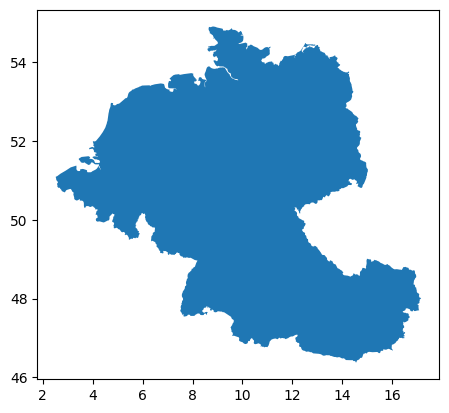

In [12]:
#%%time
#Country code can be found in the folder "Data_summary/country_geometry" in the file "Country_codes.csv"
country_codes = ["NL1", "BEL", "DEU", "AUT"]
#In the same folder we have the shapefiles for the countries as well
#Here we create a joint shape file out of the country list.

#read countries
combined_geo_df = tess.get_combined_country_geometry(country_codes)

#save shapefile
combined_geo_df.to_file("../Data_summary/country_geometry/combined_countries.shp")
# #read continent instead
# combined_geo_df = tess.get_continent_geometry("Africa", "../Data_summary/country_geometry/World_Continents.geojson")

tess.visualize_geometry(combined_geo_df) 

#Save the population density of the combined countries
tess.get_pop_density_for_geodf(combined_geo_df)




In [17]:
#%%time
import importlib
importlib.reload(tess)
#Use Population density of selected region to sample points 
raster_path = '../Data_summary/POP/selection.tif'
#probability_gdf = tess.raster_to_spatial_probability_distribution(raster_path, power=2)
# generator = tess.efficient_raster_to_spatial_probability_distribution(raster_path, power=2)
# probability_gdf = tess.create_gdf(generator, "EPSG:4326")
probability_distribution, transform, src = tess.raster_to_probability_distribution(raster_path, power=2)

/opt/homebrew/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


103


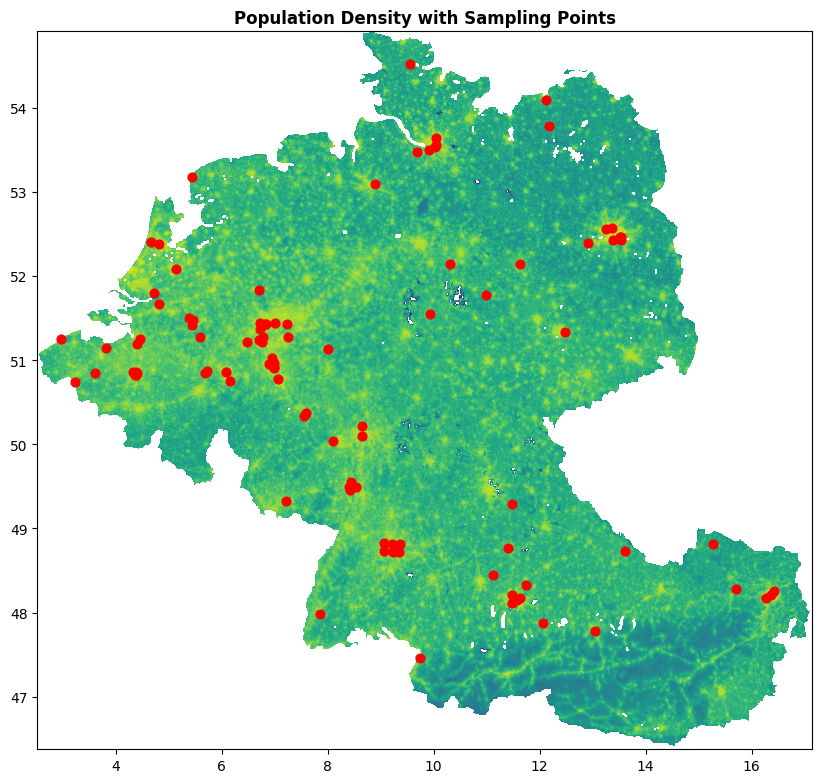

In [18]:
#%%time
import importlib
importlib.reload(tess)
points = tess.poisson_disk_sampling_with_density(probability_distribution,transform, src, radius=0.5, n_samples=100)
#add bounds to avoid infinity polygons
boundary_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([180.0,-180,180,-180] ,[90.0, 90,-90,-90]))


#add point1 to geodataframe points
points = pd.concat([boundary_points, points], ignore_index=True)

print(len(points))
# Visualize points excluding boundary points
tess.visualize_with_population(points[4:], raster_path)


**Next we create tesselation for a given sample points of region using voronoi tessellation.**
#### Alternative gridding approaches still needed
- *uniform grid*
- *hierarchical grid*


99


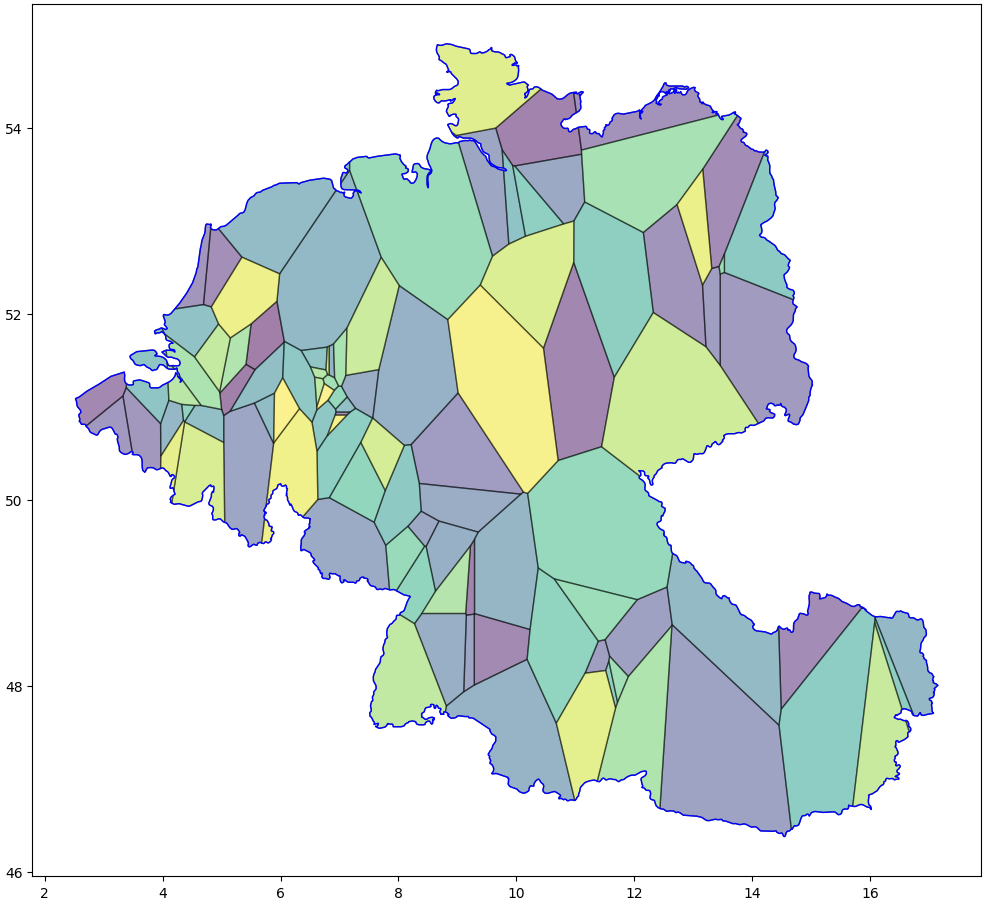

In [19]:
#%%time
#reload tess module
importlib.reload(tess)

boundary =   combined_geo_df.geometry[0]
voronoi_gdf = tess.create_voronoi_gdf(points, boundary)

print(len(voronoi_gdf))

#visulaize voronoi cells
tess.visualize_voronoi(voronoi_gdf, boundary)
#TODO check and exclude outside voronoi cells 



## Attributing Values to the Grids

Starting with Population we start creating time-series data with the available datasets. <br>
<br>
**Annually:**    GDP, Electricity Consumption <br>
**Once:**    Population, Deprivation Index, Aggricultural GDP, harmonized critical infrastructure.<br>

In [ ]:
#%%time
#result_of_timing = %time -o 
# Attribute values that have only one measurement over time

population_gdf = tess.raster_to_population_gdf(raster_path)
#TODO more datasets to be included here!
attributed_voronoi_gdf = tess.attribute_values_to_voronoi_cells(voronoi_gdf, population_gdf, 'population')
print("population done")
# Attribute values that have multiple mesuarements over time
# List of years to process
years = list(range(1993, 2020))
overalltime = 0
# Loop over each year to process GDP data
for year in years:

    raster_path = f'../Data_summary/GDP/{year}/{year}GDP.tif'
    output_raster_path = f'../Data_summary/POP/gdp_selection_{year}.tif'
    tess.selection_of_tif_for_geodf(combined_geo_df, raster_path, output_raster_path)
    #readtime = _ #save temproary variable 
    gdp_gdf = tess.raster_to_gdf(output_raster_path, name=f'gdp_{year}')
    gdp_value_name = f'gdp_{year}'  # Dynamic column name for the GDP data
    #print(readtime)
    attributed_voronoi_gdf = tess.attribute_values_to_voronoi_cells(attributed_voronoi_gdf, gdp_gdf, gdp_value_name)
    #overalltime += readtime

#print(overalltime)



In [ ]:
#save results in geodatatframe:
# They output file is located in the folder "Data_summary/Tessellation" in geojson format
tess.save_tessellation_data(points.iloc[4:], attributed_voronoi_gdf)

#NOTE: The way the data is saved should include information about the parameters used to generate the data.
#NOTE: The goal is time series data for each tesselation cell of the data of interest source [5] and [6]


## Open Tasks:

- Implement two more gridding techniques
- Establish pipline for: 
    - for each gridding technique
        - for each sampling density
            - save multiple griddings with corresponding time-series data
- Parallelize the process
- download the data from the sources
- solve issue with border gridd cells by adding additional vertices



# Subsequent analysis of data

## (1) compute correlation matrix

In [ ]:
import os
import geopandas as gpd
import seaborn as sns
import networkx as nx
import json
from shapely.geometry import mapping

# Get the current working directory
current_dir = os.getcwd()
#print(current_dir)
# Construct the correct path to the file
file_path = os.path.join('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/attributed_voronoi_all_years_1.geojson')

#read the file
gdf = gpd.read_file(file_path)


# Select only numeric columns
numeric_gdf = gdf.select_dtypes(include=[float, int])

#drop the population column
numeric_gdf = numeric_gdf.drop(columns=['population'])
# Calculate the differences between time steps
diff_gdf = numeric_gdf.diff()
#compute relative differences
relative_diff_gdf = numeric_gdf.pct_change()


transposed_gdf = relative_diff_gdf.T

# Calculate the correlation matrix of the transposed DataFrame
row_correlation_matrix = transposed_gdf.corr()

#set correlation values below abs(0.75) to 0
adjusted_corr_m = row_correlation_matrix.applymap(lambda x: 0 if abs(x) < 0.85 else x)

#delete first row and column
adjusted_corr_m = adjusted_corr_m.iloc[1:, 1:]

#save the adjusted correlation matrix
adjusted_corr_m.to_csv('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/adjusted_corr_matrix.csv')



In [ ]:
#Compute mutual information matrix
import inference as infce
import importlib
importlib.reload(infce)


# Bring the time series data into appropriate format
geojson_path = '../Data_summary/Tesselations/attributed_voronoi_all_years_1.geojson'
centroid_gdf = gpd.read_file('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/tessellation_points_1.geojson')
#count number of entries in the centroid_gdf

dataframe = infce.geojson_to_timeseries(geojson_path)

#compute percentage change for each process
dataframe = dataframe.pct_change()
#drop the first row
dataframe = dataframe.iloc[1:]
#reshape to np arraw with columns as entries
data_array = dataframe.to_numpy().T
#save the data_array
np.savetxt('../Data_summary/Tesselations/data_array.csv', data_array, delimiter=',')



# compute mutual information matrix
mi_matrix = infce.compute_MI(data_array)
#save the mutual information matrix
np.savetxt('../Data_summary/Tesselations/MI_matrix.csv', mi_matrix, delimiter=',')

#sturges rule for binning
num_bins = int(1 + np.log2(data_array.shape[1]))
#estimate perm needed for desired lowest p-value
num_perm = int(1/0.05)-1






#compute transfer entropy matrix
settings = {
    'discretise_method': 'max_ent', # Discretise continuous data into equal-sized bins
    'n_discrete_bins': num_bins,  # Number of discrete bins/levels
    'alph1': 3,
    'alph2': 3,
    'alphc': 3
}
te_matrix, p_value_matrix = infce.compute_TE(data_array,settings=settings , num_permutations=num_perm)

#save the transfer entropy matrix
np.savetxt('../Data_summary/Tesselations/TE_matrix.csv', te_matrix, delimiter=',')
#visualize transfer entropy matrix

#print number of values above 0,05 in p_value_matrix


# #compute active information storage
# data_array = data_array.T
# processes = [i for i in range(data_array.shape[1])]
# ais_values, p_values = infce.compute_AIS(data_array, processes)


#12s for 50 nodes


In [ ]:
percentile = 0
import inference as infce
import importlib
importlib.reload(infce)

 # Adjust as needed for the number of plots

#set te_matrix entries to 0 if p_value is greater than 0.05
print(np.sum(p_value_matrix < 0.05))
#print(p_values)
#read the te_matrix from saved file
te_matrix = np.loadtxt('../Data_summary/Tesselations/TE_matrix.csv', delimiter=',')
#set te_matrix entries to 0 if p_value is greater than 0.05
te_matrix[p_value_matrix > 0.05] = 0
#set te_matrix entries to 0 if lower than 1 stdev from mean
#print mean and std of te_matrix
print(np.mean(te_matrix))
print(np.std(te_matrix))
print(np.min(te_matrix))
#print only non zero values
matrix_values = te_matrix.flatten()
matrix_values = matrix_values[matrix_values != 0]




te_matrix[te_matrix < np.mean(matrix_values) - 2*np.std(matrix_values) ] = 0
print(np.count_nonzero(te_matrix))




# te_matrix[p_value_matrix > 0.05] = 0
# #count non zero elements in te_matrix
# #save the modified te_matrix
# np.savetxt('../Data_summary/Tesselations/TE_matrix_modified.csv', te_matrix, delimiter=',')
# print(np.count_nonzero(te_matrix))
# #make ais_values dict to a np array
# # ais_valuess = np.array(list(ais_values.values()))
# # print('ais', ais_valuess)
# # print('averageAISvalue', np.mean(ais_valuess))

# #print average te_matrix values
# print('averagetehmatrixvalue', np.mean(te_matrix))
# # norm_te_matrix = infce.normalize_incoming_te(te_matrix, ais_values, factor_std=0)
# #AIS_TE_ratio = infce.AIS_TE_ratio(te_matrix, ais_values,p_values)




In [ ]:
#Visualize networks simply and compare: 

# #print(AIS_TE_ratio)
# fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
# # Plot using the modified function, passing different axes
# infce.visualize_voronoi_with_network(voronoi_gdf=voronoi_gdf, boundary=boundary, centroids_gdf=centroid_gdf, correlation_matrix=mi_matrix, percentile=percentile, title='Mutual Information Network', ax=axs[0])
# infce.visualize_voronoi_with_network(voronoi_gdf=voronoi_gdf, boundary=boundary, centroids_gdf=centroid_gdf, correlation_matrix=te_matrix, percentile=0, title='Transfer Entropy Network', ax=axs[1])
# # infce.visualize_voronoi_with_network(voronoi_gdf=voronoi_gdf, boundary=boundary, centroids_gdf=centroid_gdf, correlation_matrix=norm_te_matrix, percentile=percentile, title='Mutual Information Network', ax=axs[0])
# # infce.visualize_voronoi_with_network(voronoi_gdf=voronoi_gdf, boundary=boundary, centroids_gdf=centroid_gdf, correlation_matrix=relative_AIS_TE, percentile=0, title='Transfer Entropy Network', ax=axs[1])
# # Display the combined figure
# plt.show()


In [ ]:
import numpy as np
import networkx as nx
import leidenalg as la
import igraph as ig
import importlib
importlib.reload(infce)


def partition_network(adj_matrix, directed=False):
    """
    Partitions a network into clusters using the Louvain method.

    Parameters:
    - adj_matrix (numpy.ndarray): The adjacency matrix of the network.
    - directed (bool): If True, treats the network as directed. Otherwise, treats it as undirected.

    Returns:
    - dict: A dictionary where keys are node indices and values are cluster indices.
    """
    # Create an igraph graph from the adjacency matrix
    if directed:
        g = ig.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=ig.ADJ_DIRECTED)
    else:
        g = ig.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=ig.ADJ_UNDIRECTED)
    
    # Use the Leiden method for community detection
    partition = la.find_partition(g, la.CPMVertexPartition, resolution_parameter=0.009)

    # Convert partition to a dictionary
    partition_dict = {i: membership for i, membership in enumerate(partition.membership)}

    return partition_dict


#show lenth of voronoi_gdf
print(len(voronoi_gdf))
#cluster adjacency matrix te_matrix
G = nx.from_numpy_array(te_matrix)
print(len(G))
#compute centrality for each node
centrality = nx.eigenvector_centrality(G)
#partition the network into clusters
partition = partition_network(te_matrix, directed=True)
#print number of partitions
print(len(set(partition.values())))
print(partition)
print(centrality)

#begin figure
fig, ax = plt.subplots(figsize=(5, 5))
# Visualize the network with the partition
infce.visualize_voronoi_with_analysis(voronoi_gdf, boundary, centroid_gdf, te_matrix, partition, centrality, percentile=0, title='Economic Network', figsiz=(10,10), ax=ax)

# Display the figure
plt.show()






In [ ]:
def assign_attributes_to_geojson(array, attribute_names, geojson_data):
    # Check if the number of attributes matches the number of features in the GeoJSON
    if len(array) != len(geojson_data['features']):
        raise ValueError("The number of attributes does not match the number of points in the GeoJSON file.")
    
    # Create a DataFrame from the array and attribute names
    df = pd.DataFrame(array, columns=attribute_names)
    
    # Assign attributes to each feature in the GeoJSON file
    for i, feature in enumerate(geojson_data['features']):
        for attr_name in attribute_names:
            feature['properties'][attr_name] = df.iloc[i][attr_name]
    
    return geojson_data

# necessary steps for saving centroid data

- functions to compute network properties
    - make them paralellizable
- callable function to save properties to centroid geojson
- aggregating centroid data files to one file 

In [ ]:
#load tesselation_points_1.geojson
geojson_path = '/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/tessellation_points_1.geojson'
geojson_data = json.load(open(geojson_path))
#use assign_attributes_to_geojson to assign the partition and centrality values to the geojson_data
new_geojson_data = assign_attributes_to_geojson(array=np.array(list(partition.values())), attribute_names=['partition'], geojson_data=geojson_data)
new_geojson_data = assign_attributes_to_geojson(array=np.array(list(centrality.values())), attribute_names=['centrality'], geojson_data=new_geojson_data)
#save new data file using .tofile
#new_geojson_data.to_file('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/attributed_points.geojson', driver='GeoJSON')
# Convert the modified GeoJSON data to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Save the modified GeoJSON file
gdf.to_file('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/attributed_points.geojson', driver='GeoJSON')



- shape file for africa 
- pipline for centroid values 
- 500 nodes as upper limit 
- give config file parameters 



In [ ]:
# def create_dataframe_from_voronoi(voronoi_gdf_path):

#     dataframe = infce.geojson_to_timeseries(geojson_path)

#     #compute percentage change for each process
#     dataframe = dataframe.pct_change()
#     #drop the first row
#     dataframe = dataframe.iloc[1:]
#     #reshape to np arraw with columns as entries
#     data_array = dataframe.to_numpy().T

#     return data_array

# def compute_TE_significance(data_array,):
#     #sturges rule for binning
#     num_bins = int(1 + np.log2(data_array.shape[1]))
#     #estimate perm needed for desired lowest p-value
#     num_perm = int(1/0.05)-1
#     #compute transfer entropy matrix
#     settings = {
#         'discretise_method': 'max_ent', # Discretise continuous data into equal-sized bins
#         'n_discrete_bins': num_bins,  # Number of discrete bins/levels
#         'alph1': 3,
#         'alph2': 3,
#         'alphc': 3
#     }
#     te_matrix, p_value_matrix = infce.compute_TE(data_array,settings=settings , num_permutations=num_perm)
    
#     return te_matrix, p_value_matrix

# def correct_TE_matrix(te_matrix, p_value_matrix):
#     "Correct for relevant subset of Te matrix by correcting for significance and tie strength"
#     te_matrix[p_value_matrix > 0.051] = 0
#     matrix_values = te_matrix.flatten()
#     matrix_nozero = matrix_values[matrix_values != 0]
#     #only consider values above 1 std from mean and enough entries exist
#     if len(matrix_nozero) > 0.01*len(matrix_values):
#         te_matrix[te_matrix < np.mean(matrix_values) + np.std(matrix_values) ] = 0
    
#     return te_matrix

# def partition_network(adj_matrix, directed=False):
#     """
#     Partitions a network into clusters using the Louvain method.

#     Parameters:
#     - adj_matrix (numpy.ndarray): The adjacency matrix of the network.
#     - directed (bool): If True, treats the network as directed. Otherwise, treats it as undirected.

#     Returns:
#     - dict: A dictionary where keys are node indices and values are cluster indices.
#     """
#     # Create an igraph graph from the adjacency matrix
#     if directed:
#         g = ig.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=ig.ADJ_DIRECTED)
#     else:
#         g = ig.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=ig.ADJ_UNDIRECTED)
    
#     # Use the Leiden method for community detection
#     partition = la.find_partition(g, la.CPMVertexPartition, resolution_parameter=0.01)

#     # Convert partition to a dictionary
#     partition_dict = {i: membership for i, membership in enumerate(partition.membership)}

#     return partition_dict

# def measure_attributes_of_graph(te_matrix):
#     G = nx.from_numpy_array(te_matrix)
    
#     # Compute centrality for each node
#     centrality = nx.eigenvector_centrality(G)
#     partition = partition_network(te_matrix, directed=True)
    
#     # Compute additional metrics
#     degree_centrality = nx.degree_centrality(G)
#     betweenness_centrality = nx.betweenness_centrality(G)
#     closeness_centrality = nx.closeness_centrality(G)
#     pagerank = nx.pagerank(G)
#     clustering_coefficient = nx.clustering(G)
    
#     # Compute the number of different partitions a node is connected to
#     partition_neighbors_count = {}
#     for node in G.nodes():
#         neighbor_partitions = {partition[neighbor] for neighbor in G.neighbors(node)}
#         partition_neighbors_count[node] = len(neighbor_partitions)
    
#     # Combine all metrics into a dictionary
#     attributes = {}
#     for node in G.nodes():
#         attributes[node] = {
#             'degree_centrality': degree_centrality[node],
#             'betweenness_centrality': betweenness_centrality[node],
#             'closeness_centrality': closeness_centrality[node],
#             'eigenvector_centrality': centrality[node],
#             'pagerank': pagerank[node],
#             'clustering_coefficient': clustering_coefficient[node],
#             'partition': partition[node],
#             'partition_neighbors_count': partition_neighbors_count[node]
#         }

#     return attributes

In [ ]:
import igraph as ig
#reload inference module
importlib.reload(infce)




# call the functions in sequence
geojson_path = '../Data_summary/Tesselations/attributed_voronoi_all_years_1.geojson'

#pass input AND output path 

data_array = infce.create_dataframe_from_voronoi(geojson_path)
te_matrix, p_value_matrix = infce.compute_TE_significance(data_array)
print("success")
te_matrix = infce.correct_TE_matrix(te_matrix, p_value_matrix, save=False)
attributes = infce.measure_attributes_of_graph(te_matrix)

geojson_path = '/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/tessellation_points_1.geojson'
geojson_data = json.load(open(geojson_path))
new_geojson_data = infce.assign_attributes_to_geojson(attributes, geojson_data=geojson_data)
#save new data file using .tofile
# Convert updated GeoJSON to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(new_geojson_data['features'])

# Save the new GeoDataFrame to a file
gdf.to_file('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/new_attributed_points.geojson', driver='GeoJSON')




#assign attributes to geojson
# for attributes assign to point geojson file 
#use output path to save the file 


#submission scripts





# Visualizations of results


In [ ]:
def harmonize_and_merge_geojson(file1_path, file2_path, output_file_path):
    """
    Harmonize the centrality property and merge two GeoJSON files into one.
    
    Parameters:
    - file1_path: str, path to the first GeoJSON file
    - file2_path: str, path to the second GeoJSON file
    - output_file_path: str, path where the merged GeoJSON file will be saved
    
    Returns:
    - None
    """
    # Read the files into GeoDataFrames
    gdf1 = gpd.read_file(file1_path)
    gdf2 = gpd.read_file(file2_path)
    
    # Harmonize the centrality property
    if 'degree_centrality' in gdf2.columns:
        gdf2 = gdf2.rename(columns={'degree_centrality': 'centrality'})
    
    # Select only the necessary columns for merging
    gdf1_reduced = gdf1[['partition', 'centrality', 'geometry']]
    gdf2_reduced = gdf2[['partition', 'centrality', 'geometry']]
    
    # Merge the two GeoDataFrames
    merged_gdf = gpd.GeoDataFrame(pd.concat([gdf1_reduced, gdf2_reduced], ignore_index=True))
    
    # Save the merged GeoDataFrame to a new GeoJSON file
    merged_gdf.to_file(output_file_path, driver='GeoJSON')
    print("xesss")


#call the function
file1_path = '/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Archive/merged_attributed_points.geojson'
file2_path = '/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Archive/attributed_points250.geojson'
output_file_path = '/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Archive/merged_attributed_points2.geojson'
harmonize_and_merge_geojson(file1_path, file2_path, output_file_path)

In [ ]:
from matplotlib.patches import PathPatch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize

def create_heatmap(shapefile_path, geojson_path, attribute, sigma=2, grid_resolution=200):
    # Load the shapefile and GeoJSON data
    shapefile = gpd.read_file(shapefile_path)
    geojson_data = gpd.read_file(geojson_path)
    
    # Extract the coordinates and attribute values from the GeoJSON data
    points = np.array([(geom.x, geom.y) for geom in geojson_data.geometry])
    values = geojson_data[attribute].values
    
    # Create a grid over the shapefile's extent
    minx, miny, maxx, maxy = shapefile.total_bounds
    grid_x, grid_y = np.mgrid[minx:maxx:complex(grid_resolution), miny:maxy:complex(grid_resolution)]
    
    # Interpolate the values using griddata with nearest method to ensure the entire area is filled
    grid_z_nearest = griddata(points, values, (grid_x, grid_y), method='nearest')
    
    # Apply Gaussian smoothing
    grid_z_smoothed = gaussian_filter(grid_z_nearest, sigma=sigma)
    
    # Mask the grid to the shapefile
    mask = np.zeros_like(grid_z_smoothed, dtype=bool)
    for polygon in shapefile.geometry:
        if isinstance(polygon, Polygon):
            # Get the points inside the polygon
            grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T
            mask_polygon = np.array([polygon.contains(Point(x, y)) for x, y in grid_points]).reshape(grid_z_smoothed.shape)
            mask |= mask_polygon
    
    grid_z_masked = np.ma.masked_where(~mask, grid_z_smoothed)
    
    # Plot the heatmap
    plt.figure(figsize=(10, 10))
    norm = Normalize(vmin=np.min(values), vmax=np.max(values))
    plt.imshow(grid_z_masked.T, extent=(minx, maxx, miny, maxy), origin='lower', cmap='viridis', norm=norm)
    plt.colorbar(label=attribute)
    shapefile.boundary.plot(ax=plt.gca(), edgecolor='k')
    #plt.title(f'Heatmap of {attribute}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Example usage
shapefile_path = '../Data_summary/country_geometry/combined_countries.shp'
geojson_path = '../Data_summary/Archive/merged_attributed_points.geojson'
attribute = 'centrality'  # Replace with the desired attribute from the GeoJSON file

create_heatmap(shapefile_path, geojson_path, attribute)


In [ ]:
from scipy.stats import gaussian_kde

def plot_gdp_density(*file_paths):
    plt.style.use('science')
    plt.figure(figsize=(6, 4))

    for file_path in file_paths:
        # Load the GeoJSON file
        gdf = gpd.read_file(file_path)

        # Extract the GDP columns
        gdp_columns = [col for col in gdf.columns if col.startswith('gdp_')]
        
        # Combine GDP data into a single series
        gdp_data = pd.concat([gdf[col] for col in gdp_columns])

        # Plot the probability density distribution
        density = gdp_data.plot(kind='density', label=file_path.split('_')[-1].split('.')[0])

        # # Normalize the y-axis to the maximum value of the density
        # y_max = density.get_lines()[-1].get_ydata().max()
        # density.get_lines()[-1].set_ydata(density.get_lines()[-1].get_ydata() / y_max)


    plt.title('Probability Density Distribution of GDP Over All Years')
    plt.xlabel('GDP')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_gdp_density2(*file_paths):
    plt.style.use('science')
    plt.figure(figsize=(10, 3))

    for file_path in file_paths:
        # Load the GeoJSON file
        gdf = gpd.read_file(file_path)

        # Extract the GDP columns
        gdp_columns = [col for col in gdf.columns if col.startswith('gdp_')]
        
        # Combine GDP data into a single series
        gdp_data = pd.concat([gdf[col] for col in gdp_columns]).dropna()
        
        # Calculate the density
        kde = gaussian_kde(gdp_data)
        x_values = np.linspace(gdp_data.min(), gdp_data.max(), 1000)
        y_values = kde(x_values)
        
        # Normalize the y-values
        y_values /= y_values.max()
        
        # Plot the normalized density
        plt.plot(x_values, y_values, label=file_path.split('_')[-1].split('.')[0])
    #plt.title('Probability Density Distribution of GDP Over All Years')
    plt.xlabel('GDP')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()



plot_gdp_density(
    '../Data_summary/Archive/attributed_voronoi_all_years_020.geojson',
    '../Data_summary/Archive/attributed_voronoi_all_years_050.geojson',
    '../Data_summary/Archive/attributed_voronoi_all_years_100.geojson',
    '../Data_summary/Archive/attributed_voronoi_all_years_250.geojson'


)

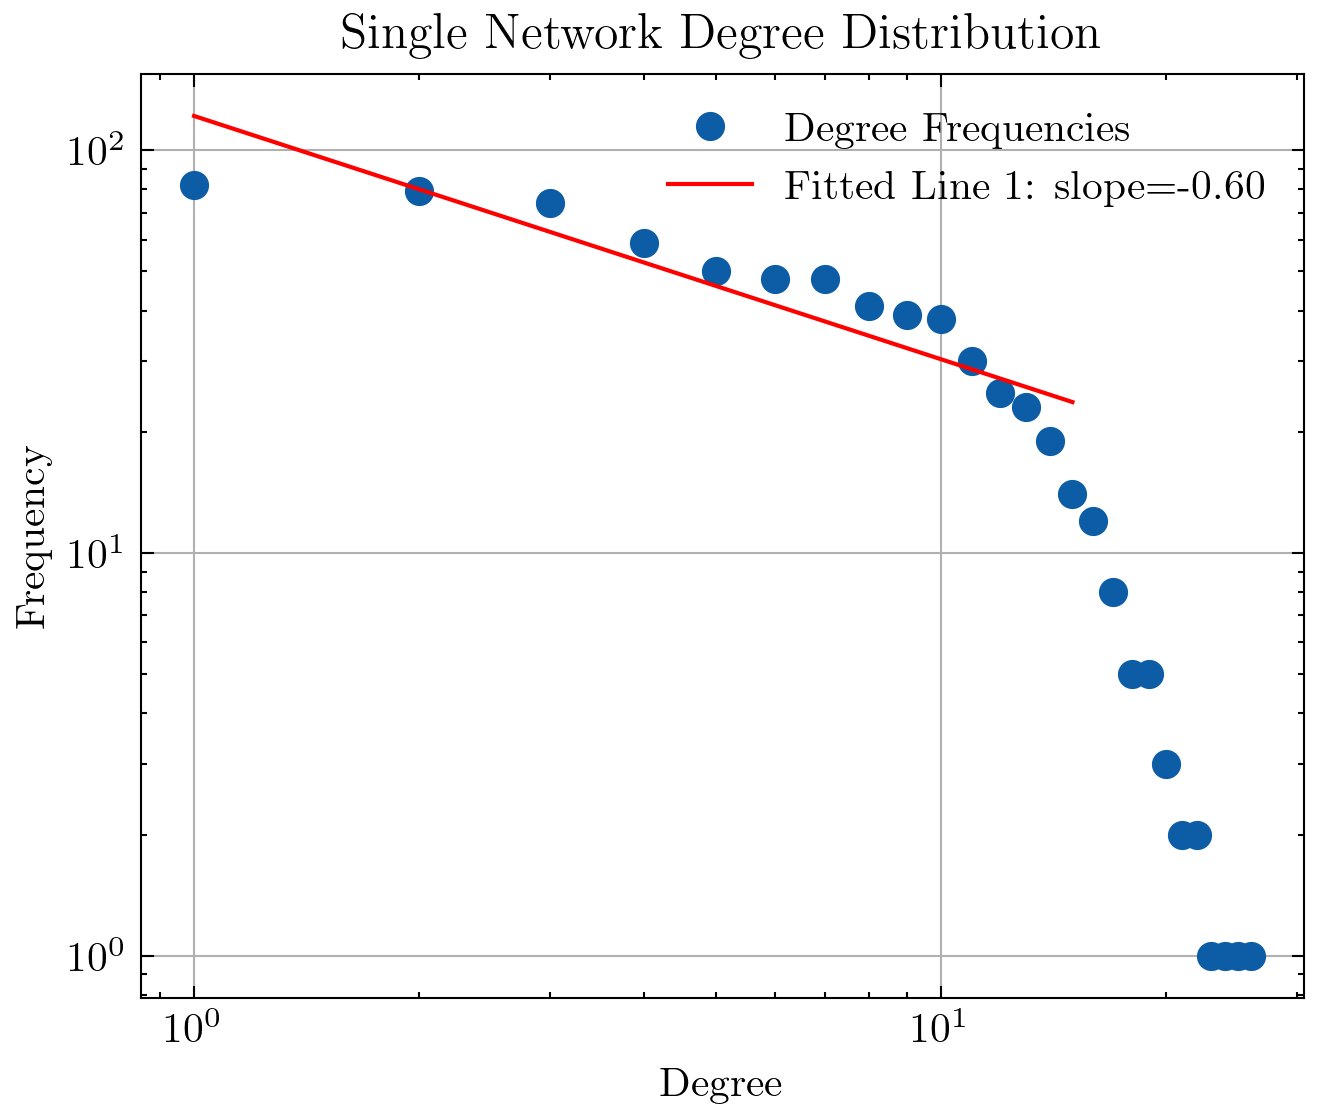

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy.stats import linregress
import scienceplots

# Load the adjacency matrix
file_path = '../Data_summary/Archive/TE_matrix_modified.csv'

#read csv as adjacency of directed graph
adj_matrix = pd.read_csv(file_path, header=None)
#convert to numpy array
adj_matrix = adj_matrix.to_numpy()
#convert to networkx graph
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)


# Calculate node degrees (in-degree and out-degree separately for directed graphs)
in_degrees = [degree for node, degree in G.in_degree()]
out_degrees = [degree for node, degree in G.out_degree()]

# Combine in-degree and out-degrees into a single list
degrees = in_degrees + out_degrees

# Compute frequency distribution
degree_counts = Counter(degrees)
sorted_counts = sorted(degree_counts.items(), key=lambda x: x[1], reverse=True)

# Log-log plot
ranks = np.arange(1, len(sorted_counts) + 1)
frequencies = np.array([count for degree, count in sorted_counts])

# Define the first range for the fit
r_min1, r_max1 = 1, 15  # Example range, adjust as needed
subset1 = (ranks >= r_min1) & (ranks <= r_max1)

# Perform first linear regression on the first subset
log_ranks1 = np.log(ranks[subset1])
log_frequencies1 = np.log(frequencies[subset1])
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(log_ranks1, log_frequencies1)

# Define the second range for the fit
r_min2, r_max2 = 16, 30  # Example range, adjust as needed
subset2 = (ranks >= r_min2) & (ranks <= r_max2)

# Perform second linear regression on the second subset
log_ranks2 = np.log(ranks[subset2])
log_frequencies2 = np.log(frequencies[subset2])
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(log_ranks2, log_frequencies2)
plt.style.use('science')
# Plot the data points
plt.figure(figsize=(5, 4))
plt.loglog(ranks, frequencies, marker='o', linestyle='none', label='Degree Frequencies')

# Plot the first fitted line limited to the range
fitted_ranks1 = np.arange(r_min1, r_max1 + 1)
fitted_line1 = np.exp(intercept1) * fitted_ranks1**slope1
plt.loglog(fitted_ranks1, fitted_line1, color='red', label=f'Fitted Line 1: slope={slope1:.2f}')

# # Plot the second fitted line limited to the range
# fitted_ranks2 = np.arange(r_min2, r_max2 + 1)
# fitted_line2 = np.exp(intercept2) * fitted_ranks2**slope2
# plt.loglog(fitted_ranks2, fitted_line2, color='green', label=f'Fitted Line 2: slope={slope2:.2f}')
# #plt.loglog(ranks, frequencies, marker='o', linestyle='none', label='Degree Frequencies')

# Plot the fitted line
#set high resolution
plt.rcParams['figure.dpi'] = 500

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Single Network Degree Distribution')
plt.grid(True)
plt.legend()
plt.show()




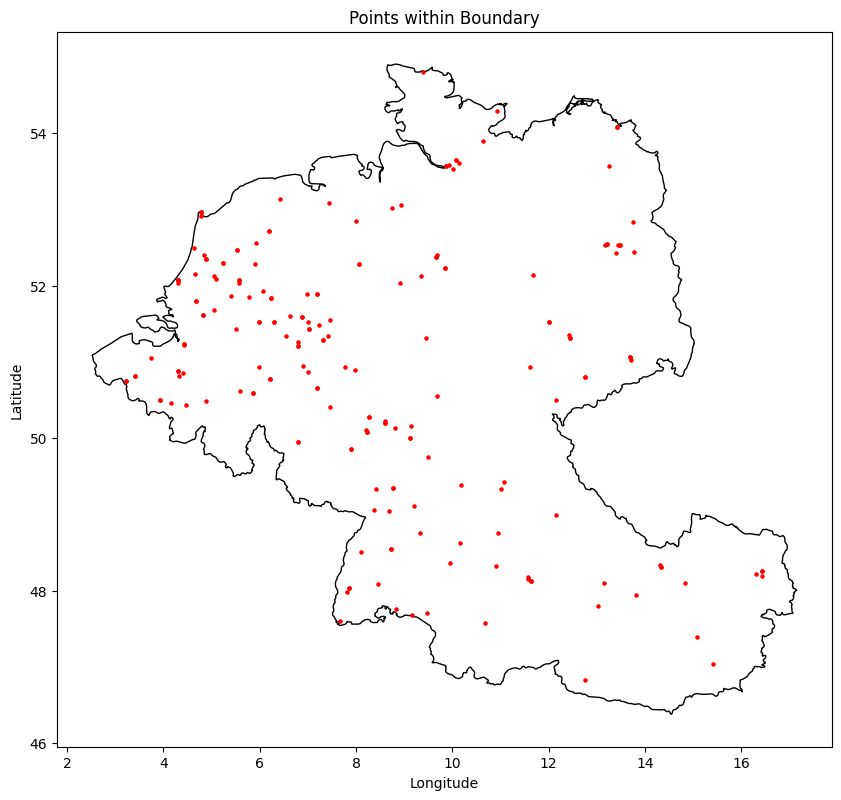

In [3]:
def plot_points_within_boundary(geojson_path, shapefile_path):
    # Load the GeoJSON file containing the points
    points_gdf = gpd.read_file(geojson_path)
    
    # Load the shapefile containing the boundary
    boundary_gdf = gpd.read_file(shapefile_path)
    
    # Plot the boundary
    fig, ax = plt.subplots(figsize=(10, 10))
    boundary_gdf.plot(ax=ax, edgecolor='black', color='none')
    
    # Plot the points within the boundary
    points_gdf.plot(ax=ax, color='red', markersize=5)
    
    # Set the title and show the plot
    plt.title('Points within Boundary')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

plot_points_within_boundary('../Data_summary/Archive/merged_attributed_points.geojson', '../Data_summary/country_geometry/combined_countries.shp')

94


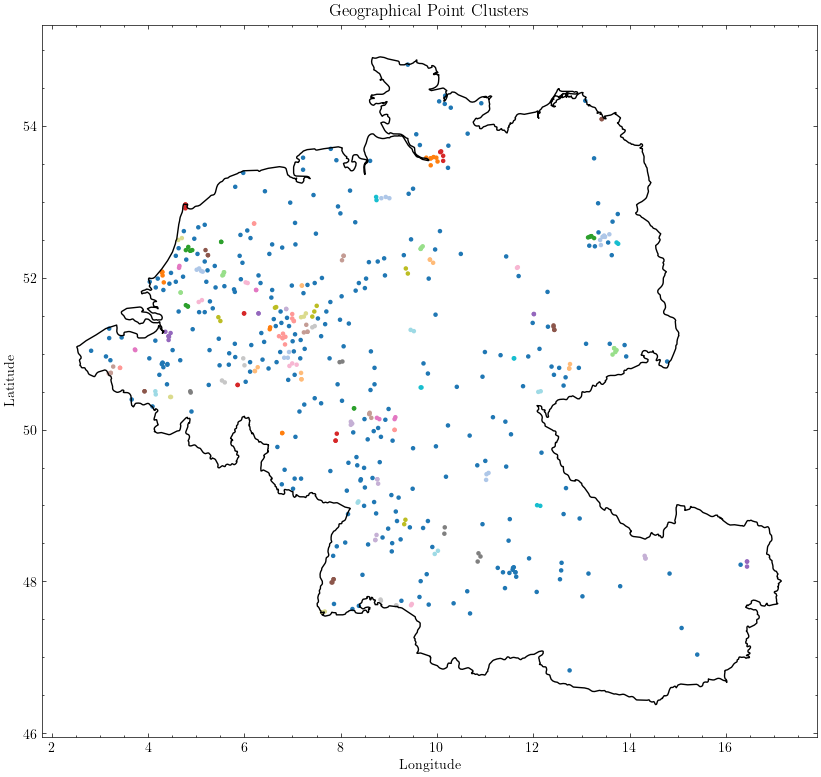

In [64]:
import geopandas as gpd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def cluster_geographical_points(geojson_path, shapefile_path, eps=0.05, min_samples=2):
    # Load the GeoJSON file containing the points
    points_gdf = gpd.read_file(geojson_path)
    
    # Extract the coordinates of the points
    coords = points_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
    # Perform DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    #print number of different clusters
    print(len(set(clustering.labels_)))
    points_gdf['cluster'] = clustering.labels_
    
    boundary_gdf = gpd.read_file(shapefile_path)
    
    # Plot the clusters
    fig, ax = plt.subplots(figsize=(10, 10))
    points_gdf.plot(ax=ax, column='cluster',  markersize=5, cmap='tab20')
    boundary_gdf.plot(ax=ax, edgecolor='black', color='none')
    
    plt.title('Geographical Point Clusters')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    
    return points_gdf

#Example usage:
clustered_points_gdf = cluster_geographical_points('../Data_summary/Archive/merged_attributed_points2.geojson','../Data_summary/country_geometry/combined_countries.shp', eps=0.1, min_samples=2)


In [63]:
import geopandas as gpd

# Load the shapefile
shape_path = '../Data_summary/UrbanAreas/WUA/Urban.shp'
gdf = gpd.read_file(shape_path)


# Ensure the GeoDataFrame has a projected coordinate system (not in degrees)
if gdf.crs.is_geographic:
    # Project to a suitable UTM zone or any other projected CRS
    gdf = gdf.to_crs(gdf.estimate_utm_crs())


# Compute the area in square kilometers
gdf['area_km2'] = gdf.geometry.area / 10**6

# Print a few rows to inspect the calculated areas
print(gdf[['Name', 'area_km2']].head())

# Filter all entries with area less than 100 km²
gdf = gdf[gdf['area_km2'] > 130000]

# Print the number of features after filtering
print(len(gdf))

# Print the first few rows to check
print(gdf['area_km2'])

# Save the result to a new GeoJSON file
output_path = '../Data_summary/UrbanAreas/urban_area.geojson'
gdf.to_file(output_path, driver='GeoJSON')

print(f"Filtered GeoJSON saved to {output_path}")







       Name   area_km2
0  Brighton  43.746749
1    'Ar'ar  19.772350
2  'Atbarah  28.990493
3   Brikama  10.591217
4     'Ibri  34.297147
1
2161    438620.633155
Name: area_km2, dtype: float64
Filtered GeoJSON saved to ../Data_summary/UrbanAreas/urban_area.geojson


/opt/homebrew/lib/python3.11/site-packages/shapely/measurement.py:44: RuntimeWarning: invalid value encountered in area
  return lib.area(geometry, **kwargs)


19005.535128788455


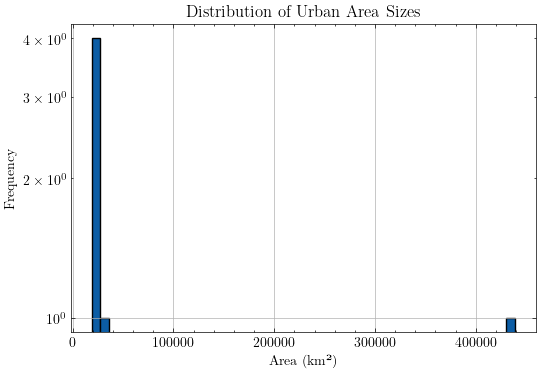

In [60]:
#print list of areas 
print(min(list(gdf['area_km2'])))

#read gdf
output_path = '../Data_summary/UrbanAreas/urban_area.geojson'
gdf = gpd.read_file(output_path)
#plot distribution of urban areas
plt.style.use('science')
plt.figure(figsize=(6, 4))
#use log scale
plt.hist(gdf['area_km2'], bins=50, edgecolor='black', log=True)
plt.xlabel('Area (km²)')
plt.ylabel('Frequency')
plt.title('Distribution of Urban Area Sizes')
plt.grid(True)
plt.show()


In [9]:
import cpnet
import networkx as nx
import numpy as np

algorithm = cpnet.KM_config()

#load the adjacency matrix from Tesselations folder
adj_matrix = np.loadtxt('../Data_summary/Tesselations/TE_matrix.csv', delimiter=',')
G = nx.from_numpy_array(adj_matrix)
algorithm.detect(G)
coreness = algorithm.get_coreness()



{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1, 6: 1, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1}
